# Step 1 | Exploring the Data

## Step 1.1 | Import Libaries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1.2 | Load Data

In [2]:
# Load data
pd.set_option('display.max_columns', None)
scores = pd.read_csv('data/compas-scores.csv')

print(scores)

      two_year_recid score_text  decile_score              race       age_cat  \
0                  1        Low             3  African-American       25 - 45   
1                  1        Low             4  African-American  Less than 25   
2                  1     Medium             6         Caucasian       25 - 45   
3                  0        Low             1         Caucasian       25 - 45   
4                  0        Low             4         Caucasian       25 - 45   
...              ...        ...           ...               ...           ...   
5273               1        Low             2  African-American       25 - 45   
5274               0       High             9  African-American  Less than 25   
5275               0     Medium             7  African-American  Less than 25   
5276               0        Low             3  African-American  Less than 25   
5277               0        Low             2  African-American       25 - 45   

     c_charge_degree     se

## Step 1.3 | Mean "priors_count" by "score_text" and "race"

In [3]:
# Grouped analysis: comparing priors_count by score_text and race
grouped_analysis = scores.groupby(['score_text', 'race']         # Group data by score_text and race
                                 ).agg({'priors_count': 'mean'}  # Compute mean of priors_count
                                      ).reset_index()            # Reset index for easier readability

In [4]:
# Pivot data for side-by-side comparison
comparison_table = grouped_analysis.pivot(index='score_text', 
                                          columns='race', 
                                          values='priors_count'
                                         ).reindex(['Low', 'Medium', 'High'])  # Sort score_text rows

print("Side-by-Side Comparison of Mean Priors Count by Race:\n")
print(comparison_table)

Side-by-Side Comparison of Mean Priors Count by Race:

race        African-American  Caucasian
score_text                             
Low                 1.945765   1.508884
Medium              4.544715   3.327696
High                7.532544   5.008969


## Step 1.4 | Distributions of "age_cat" and "race"

In [5]:
# Descriptive stats: distributions of 'age_cat' and 'race'
age_cat_distribution = scores['age_cat'].value_counts()
race_distribution = scores['race'].value_counts()

print("\nAge Category Distribution:\n", age_cat_distribution)
print("\nRace Distribution:\n", race_distribution)


Age Category Distribution:
 age_cat
25 - 45            3026
Less than 25       1156
Greater than 45    1096
Name: count, dtype: int64

Race Distribution:
 race
African-American    3175
Caucasian           2103
Name: count, dtype: int64


# Step 2 | Preprocessing

## Step 2.1 | Create Binary Dependent Variable

In [6]:
scores["high_risk"] = (scores["score_text"] == "High").astype(int)
print(scores)

      two_year_recid score_text  decile_score              race       age_cat  \
0                  1        Low             3  African-American       25 - 45   
1                  1        Low             4  African-American  Less than 25   
2                  1     Medium             6         Caucasian       25 - 45   
3                  0        Low             1         Caucasian       25 - 45   
4                  0        Low             4         Caucasian       25 - 45   
...              ...        ...           ...               ...           ...   
5273               1        Low             2  African-American       25 - 45   
5274               0       High             9  African-American  Less than 25   
5275               0     Medium             7  African-American  Less than 25   
5276               0        Low             3  African-American  Less than 25   
5277               0        Low             2  African-American       25 - 45   

     c_charge_degree     se

# Step 3 | Regression Model

## Step 3.1 | Run Model

In [7]:
model = smf.logit(formula="high_risk ~ race + priors_count + age_cat + c_charge_degree + sex",
                  data=scores
                 ).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.397195
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              high_risk   No. Observations:                 5278
Model:                          Logit   Df Residuals:                     5271
Method:                           MLE   Df Model:                            6
Date:                Thu, 12 Jun 2025   Pseudo R-squ.:                  0.2114
Time:                        11:04:26   Log-Likelihood:                -2096.4
converged:                       True   LL-Null:                       -2658.2
Covariance Type:            nonrobust   LLR p-value:                1.590e-239
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.1803      0.118    -18.413      0.000      -2.412      -1.948
race[T.Caucasian]             -0.5792      0.090     -6.457      0.000      -0.755      -0.403
age_cat[T.Greater than 45]    -1.6574      0.156    -10.642      0.000      -1.963      -1.352
age_cat[T.Less than 25]        1.1628      0.091     12.747      0.000       0.984       1.342
c_charge_degree[T.M]          -0.3943      0.090     -4.396      0.000      -0.570      -0.218
sex[T.Male]                    0.1451      0.107      1.360      0.174      -0.064       0.354
priors_count                   0.2046      0.009     23.010      0.000       0.187       0.222
==============================================================================================
"""

**Analysis**

The coefficient on race[T.Caucasian] = -0.5792, p < 0.001 is statistically significant and negative. This means that Black defendants are more likely to be labeled “High Risk” than comparable white defendants with the same age, priors, sex, and charge type. This supports the claim that COMPAS’s outputs may reflect racial disparities even after adjusting for legally relevant predictors.

Also, younger defendants in general are more likely to be labeled high risk (age_cat[T.Less than 25] = 1.1628, p < 0.001).

## Step 3.2 | Error Balance (Equalized Odds, Equalized Recall)
For Error Balance, we condition on the the ground-truth labels. --> ProPublica's Approach

### Step 3.2.1 | False Negatives
The coefficient on race[T.Caucasian] = -0.4737, p < 0.001, is statistically significant and negative. This means that among people who actually did reoffend, white defendants were less likely to be labeled “High Risk” than Black defendants with similar profiles. This suggests Black defendants who actually reoffended were more likely to be correctly identified as high risk, suggesting a higher true positive rate (and thus lower false negative rate) compared to white defendants.

In [8]:
# When two_year_recid = 1
# Checking for False Negatives: Only people who DID reoffend
EB_FN_model = smf.logit(formula = "high_risk ~ race + priors_count + age_cat + c_charge_degree + sex", 
                  data = scores[scores['two_year_recid'] == 1]
                 ).fit()
EB_FN_model.summary()

Optimization terminated successfully.
         Current function value: 0.522205
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              high_risk   No. Observations:                 2483
Model:                          Logit   Df Residuals:                     2476
Method:                           MLE   Df Model:                            6
Date:                Thu, 12 Jun 2025   Pseudo R-squ.:                  0.1675
Time:                        11:04:27   Log-Likelihood:                -1296.6
converged:                       True   LL-Null:                       -1557.6
Covariance Type:            nonrobust   LLR p-value:                1.583e-109
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.6149      0.157    -10.268      0.000      -1.923      -1.307
race[T.Caucasian]             -0.4737      0.111     -4.249      0.000      -0.692      -0.255
age_cat[T.Greater than 45]    -1.5302      0.194     -7.891      0.000      -1.910      -1.150
age_cat[T.Less than 25]        0.9982      0.115      8.674      0.000       0.773       1.224
c_charge_degree[T.M]          -0.4430      0.113     -3.921      0.000      -0.664      -0.222
sex[T.Male]                    0.0604      0.141      0.430      0.667      -0.215       0.336
priors_count                   0.1760      0.011     16.295      0.000       0.155       0.197
==============================================================================================
"""

### Step 3.2.2 | False Positives
The coefficient on race[T.Caucasian] = -0.7359, p < 0.001, is statistically significant and negative. This means that among people who did not reoffend, white defendants were again less likely to be labeled “High Risk.” In other words, Black defendants were more likely to be falsely labeled as high risk compared to white defendants with similar attributes.

In [9]:
# When two_year_recid = 0
# Checking for False Positives: Only people who did NOT reoffend
EB_FP_model = smf.logit(formula = "high_risk ~ race + priors_count + age_cat + c_charge_degree + sex", 
                  data = scores[scores['two_year_recid'] == 0]
                 ).fit()
EB_FP_model.summary()

Optimization terminated successfully.
         Current function value: 0.266802
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              high_risk   No. Observations:                 2795
Model:                          Logit   Df Residuals:                     2788
Method:                           MLE   Df Model:                            6
Date:                Thu, 12 Jun 2025   Pseudo R-squ.:                  0.1640
Time:                        11:04:27   Log-Likelihood:                -745.71
converged:                       True   LL-Null:                       -892.02
Covariance Type:            nonrobust   LLR p-value:                 3.141e-60
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.6276      0.189    -13.906      0.000      -2.998      -2.257
race[T.Caucasian]             -0.7359      0.159     -4.641      0.000      -1.047      -0.425
age_cat[T.Greater than 45]    -1.4935      0.258     -5.781      0.000      -2.000      -0.987
age_cat[T.Less than 25]        1.1654      0.159      7.336      0.000       0.854       1.477
c_charge_degree[T.M]          -0.2173      0.151     -1.437      0.151      -0.514       0.079
sex[T.Male]                    0.0866      0.172      0.504      0.614      -0.250       0.423
priors_count                   0.1977      0.016     12.050      0.000       0.166       0.230
==============================================================================================
"""

### Step 3.2.3 | Error Balance Summary

These results strongly support ProPublica’s claim that COMPAS exhibits error-based racial disparities. Black defendants are more likely to be misclassified as high risk regardless of actual reoffending outcomes, suggesting unequal treatment even when controlling for key legal variables.

**Key Takeaway:** COMPAS makes more false positives and fewer false negatives for Black defendants.

## Step 3.3 | Predictive Parity (Equalized Precision)
For Predictive Parity, we condition on the the predicted labels. --> Northpointe's Approach

### Step 3.3.1 | Positive Predictive Value
The coefficient on race[T.Caucasian] = 0.1254, p = 0.482 is not statistically significant. This suggests that among people predicted to be high risk, white and Black defendants have similar actual recidivism outcomes. This supports Northpointe’s claim that predicted scores are calibrated across races when the label is "High Risk."

In [10]:
# When high_risk = 1
PP_PPV_model = smf.logit(formula = "two_year_recid ~ race + priors_count + age_cat + c_charge_degree + sex", 
                  data = scores[scores['high_risk'] == 1]
                 ).fit()
PP_PPV_model.summary()

Optimization terminated successfully.
         Current function value: 0.535792
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         two_year_recid   No. Observations:                 1068
Model:                          Logit   Df Residuals:                     1061
Method:                           MLE   Df Model:                            6
Date:                Thu, 12 Jun 2025   Pseudo R-squ.:                 0.05574
Time:                        11:04:27   Log-Likelihood:                -572.23
converged:                       True   LL-Null:                       -606.00
Covariance Type:            nonrobust   LLR p-value:                 1.294e-12
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0181      0.226      0.080      0.936      -0.425       0.462
race[T.Caucasian]              0.1254      0.179      0.703      0.482      -0.224       0.475
age_cat[T.Greater than 45]    -0.5702      0.280     -2.039      0.041      -1.118      -0.022
age_cat[T.Less than 25]        0.4814      0.172      2.799      0.005       0.144       0.819
c_charge_degree[T.M]          -0.3777      0.166     -2.273      0.023      -0.703      -0.052
sex[T.Male]                    0.4603      0.196      2.343      0.019       0.075       0.845
priors_count                   0.1003      0.015      6.612      0.000       0.071       0.130
==============================================================================================
"""

### Step 3.3.2 | Negative Predictive Value
The coefficient on race[T.Caucasian] = –0.0700, p = 0.308 is also not statistically significant. This means that for those predicted to be low or medium risk, Black and white defendants recidivate at similar rates. Again, this supports the idea that COMPAS is calibrated fairly, at least in terms of predictive parity.

In [11]:
# When high_risk = 0
PP_NPV_model = smf.logit(formula = "two_year_recid ~ race + priors_count + age_cat + c_charge_degree + sex", 
                  data = scores[scores['high_risk'] == 0]
                 ).fit()
PP_NPV_model.summary()

Optimization terminated successfully.
         Current function value: 0.625405
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         two_year_recid   No. Observations:                 4210
Model:                          Logit   Df Residuals:                     4203
Method:                           MLE   Df Model:                            6
Date:                Thu, 12 Jun 2025   Pseudo R-squ.:                 0.07113
Time:                        11:04:27   Log-Likelihood:                -2633.0
converged:                       True   LL-Null:                       -2834.6
Covariance Type:            nonrobust   LLR p-value:                 5.540e-84
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.9764      0.094    -10.371      0.000      -1.161      -0.792
race[T.Caucasian]             -0.0700      0.069     -1.019      0.308      -0.205       0.065
age_cat[T.Greater than 45]    -0.6200      0.087     -7.122      0.000      -0.791      -0.449
age_cat[T.Less than 25]        0.6250      0.086      7.274      0.000       0.457       0.793
c_charge_degree[T.M]          -0.1139      0.069     -1.638      0.101      -0.250       0.022
sex[T.Male]                    0.3209      0.084      3.824      0.000       0.156       0.485
priors_count                   0.1561      0.011     14.496      0.000       0.135       0.177
==============================================================================================
"""

### Step 3.3.3 | Predictive Parity Summary

These results support Northpointe’s argument for predictive parity. Among defendants labeled high or low risk by COMPAS, the likelihood of actual recidivism is statistically similar across racial groups, suggesting that COMPAS risk labels are equally valid predictors regardless of race.

**Key Takeaway:** For people with the same risk label, actual recidivism is similar across races. COMPAS is calibrated.

# Step 4 | Summary

## Step 4.1 | Overview of Results

A model can be well-calibrated (equal accuracy when it predicts) but still make those predictions more often for one group than another.
- Black defendants are more likely to be labeled as high risk compared to White defendants, regardless of whether they actually reoffended.
- The model is pretty accurate though, in that the relationship between its labels (High vs. Low risk) and the actual recidivism outcomes are consistent across races.

Both statements are true because fairness depends on which dimension is being prioritized - COMPAS may treat equally risky people the same (predictive parity) but still label one group as risky more often, leading to disparate error rates.

While COMPAS labels Black defendants as high risk more often, the actual recidivism rate in the dataset is also higher. The increase in prediction rate is proportional to the increase in actual risk, suggesting that label calibration is intact. This supports predictive parity, even though the overall rate of labeling differs across groups.

### Step 4.1.1 | Predicted vs. Actual by Race

In [26]:
# Group by race
grouped = scores.groupby('race')

# Calculate % predicted high risk
predicted_high_risk = grouped['high_risk'].mean()

# Calculate % who actually recidivated
actual_recid = grouped['two_year_recid'].mean()

In [29]:
# Combine into a single DataFrame for plotting
bar_df = pd.DataFrame({
    'Predicted High Risk': predicted_high_risk,
    'Actual Recidivism': actual_recid
}).reset_index()

# Melt to long format for seaborn
bar_df_melted = bar_df.melt(id_vars='race', var_name='Metric', value_name='Rate')
print(bar_df_melted)

               race               Metric      Rate
0  African-American  Predicted High Risk  0.266142
1         Caucasian  Predicted High Risk  0.106039
2  African-American    Actual Recidivism  0.523150
3         Caucasian    Actual Recidivism  0.390870


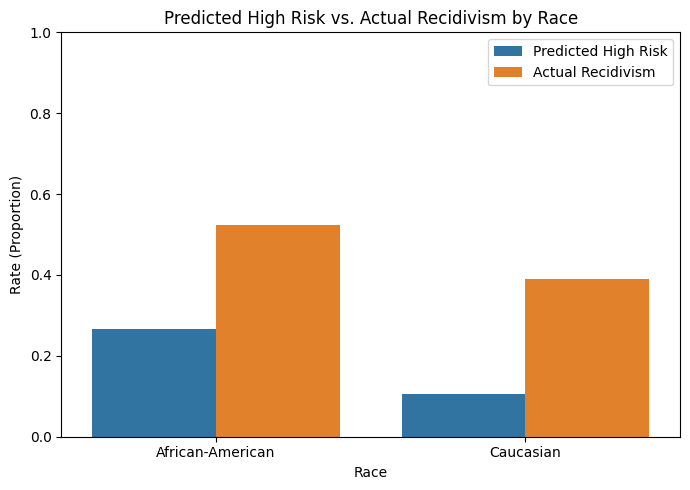

In [28]:
# Plot
plt.figure(figsize=(7, 5))
sns.barplot(data=bar_df_melted, x='race', y='Rate', hue='Metric')
plt.title('Predicted High Risk vs. Actual Recidivism by Race')
plt.ylabel('Rate (Proportion)')
plt.xlabel('Race')
plt.ylim(0, 1)
plt.legend(title='')
plt.tight_layout()
plt.show()

### Step 4.1.2 | Prediction Gap by Race

In [33]:
bar_df = pd.DataFrame({
    'race': ['African-American', 'Caucasian'],
    'Predicted High Risk': [0.266142, 0.106039],
    'Actual Recidivism': [0.523150, 0.390870]
})

# Add Overprediction Gap
bar_df['Prediction Gap'] = bar_df['Predicted High Risk'] - bar_df['Actual Recidivism']

In [34]:
# Melt to long format for grouped bar chart
gap_df_melted = bar_df.melt(id_vars='race', 
                            value_vars=['Predicted High Risk', 'Actual Recidivism', 'Prediction Gap'], 
                            var_name='Metric', value_name='Rate')

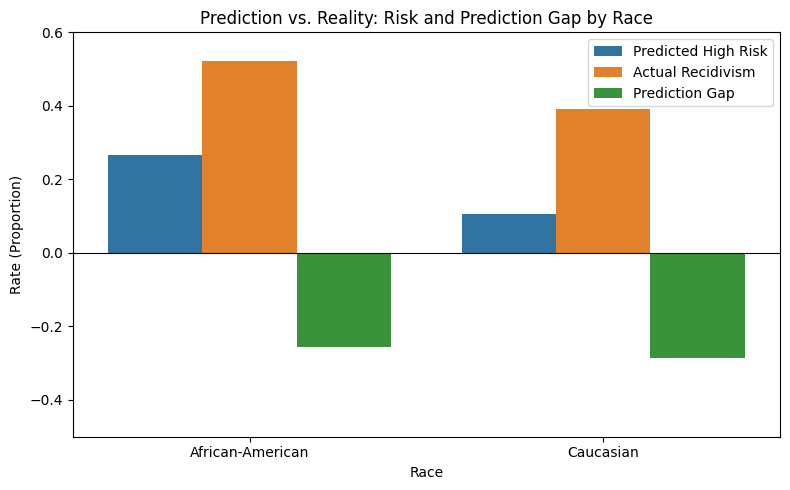

In [35]:
# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=gap_df_melted, x='race', y='Rate', hue='Metric')
plt.title('Prediction vs. Reality: Risk and Prediction Gap by Race')
plt.ylabel('Rate (Proportion)')
plt.xlabel('Race')
plt.ylim(-0.5, 0.6)
plt.axhline(0, color='black', linewidth=0.8)
plt.legend(title='')
plt.tight_layout()
plt.show()

## Step 4.2 | Results (All Defendants)

### Step 4.2.1 | Confusion Matrix (Values)

In [37]:
# Step 1: Compute confusion matrix values
y_true = scores['two_year_recid']
y_pred = scores['high_risk']

cm = confusion_matrix(y_true, y_pred)
labels = ['Did Not Reoffend', 'Reoffended']
pred_labels = ['Low/Medium Risk', 'High Risk']

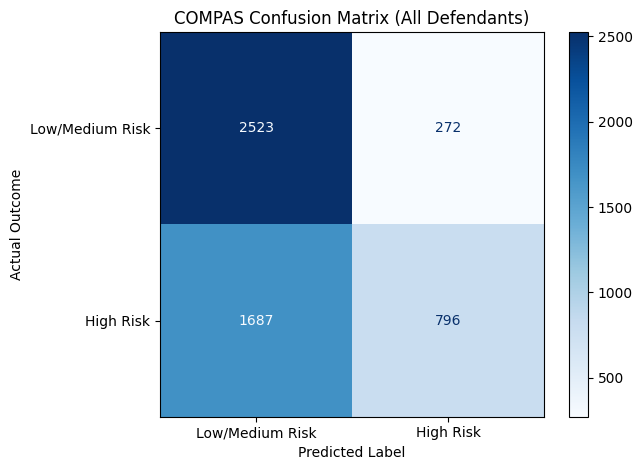

In [38]:
# Step 2: Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pred_labels)
disp.plot(cmap='Blues')
plt.title("COMPAS Confusion Matrix (All Defendants)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Outcome")
plt.tight_layout()
plt.show()

### Step 4.2.2 | Classification Metrics

In [39]:
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=labels, digits=3))

=== Classification Report ===
                  precision    recall  f1-score   support

Did Not Reoffend      0.599     0.903     0.720      2795
      Reoffended      0.745     0.321     0.448      2483

        accuracy                          0.629      5278
       macro avg      0.672     0.612     0.584      5278
    weighted avg      0.668     0.629     0.592      5278



## Step 4.3 | Results (By Race)

### Step 4.3.1 | Confusion Matrix (Values)


--- Confusion Matrix for African-American ---


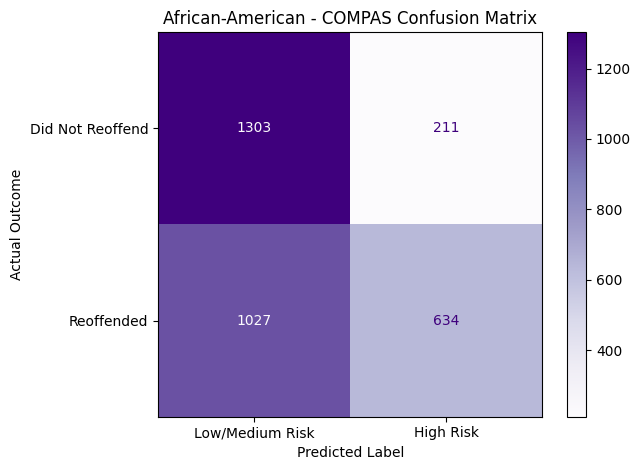


--- Confusion Matrix for Caucasian ---


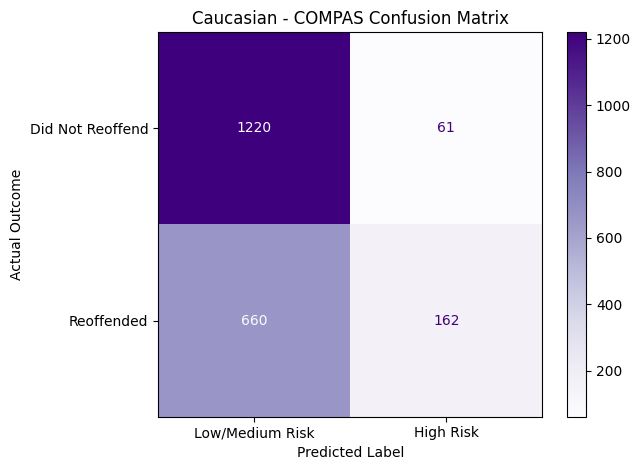

In [15]:
pred_labels = ['Low/Medium Risk', 'High Risk']
true_labels = ['Did Not Reoffend', 'Reoffended']  # Custom Y-axis labels

for race_group in ['African-American', 'Caucasian']:
    print(f"\n--- Confusion Matrix for {race_group} ---")
    
    sub = scores[scores['race'] == race_group]
    y_true_r = sub['two_year_recid']
    y_pred_r = sub['high_risk']
    
    cm_r = confusion_matrix(y_true_r, y_pred_r, labels=[0, 1])  # Ensure consistent order

    disp_r = ConfusionMatrixDisplay(confusion_matrix=cm_r,
                                    display_labels=pred_labels)  # X-axis = prediction

    # Plot with custom Y-axis tick labels
    fig, ax = plt.subplots()
    disp_r.plot(cmap='Purples', ax=ax)
    ax.set_title(f"{race_group} - COMPAS Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("Actual Outcome")
    ax.set_yticklabels(true_labels)
    plt.tight_layout()
    plt.show()

### Step 4.3.2 | Confusion Matrix (Percentages)

In [16]:
race_groups = ['African-American', 'Caucasian']
pred_labels = ['Low/Medium Risk', 'High Risk']
true_labels = ['Did Not Reoffend', 'Reoffended']


=== Confusion Matrix for African-American (Percentages) ===


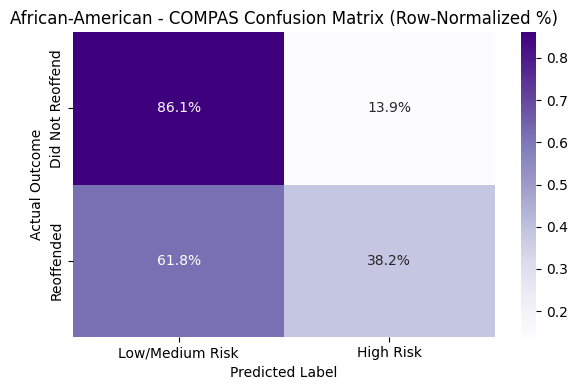

=== Classification Report ===
                  precision    recall  f1-score   support

Did Not Reoffend      0.559     0.861     0.678      1514
      Reoffended      0.750     0.382     0.506      1661

        accuracy                          0.610      3175
       macro avg      0.655     0.621     0.592      3175
    weighted avg      0.659     0.610     0.588      3175


=== Confusion Matrix for Caucasian (Percentages) ===


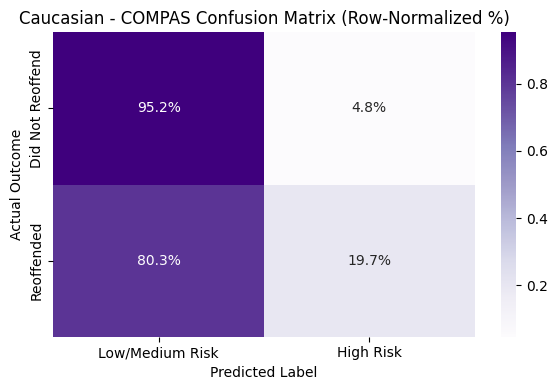

=== Classification Report ===
                  precision    recall  f1-score   support

Did Not Reoffend      0.649     0.952     0.772      1281
      Reoffended      0.726     0.197     0.310       822

        accuracy                          0.657      2103
       macro avg      0.688     0.575     0.541      2103
    weighted avg      0.679     0.657     0.591      2103



In [17]:
for race_group in race_groups:
    print(f"\n=== Confusion Matrix for {race_group} (Percentages) ===")
    
    sub = scores[scores['race'] == race_group]
    y_true = sub['two_year_recid']
    y_pred = sub['high_risk']
    
    # Raw confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    # Convert to percentages (row-wise normalization)
    cm_percent = cm.astype(float)
    row_sums = cm_percent.sum(axis=1, keepdims=True)
    cm_percent = np.divide(cm_percent, row_sums, out=np.zeros_like(cm_percent), where=row_sums!=0)
    
    # Plot using heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_percent, annot=True, fmt=".1%", cmap="Purples", xticklabels=pred_labels, yticklabels=true_labels)
    plt.title(f"{race_group} - COMPAS Confusion Matrix (Row-Normalized %)")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Outcome")
    plt.tight_layout()
    plt.show()
    
    # Print classification metrics (not percentages, but helpful for context)
    print("=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=true_labels, digits=3))

# Step 5 | Charts

## Step 5.1 | Error Balance: False Negative Rate by Race

In [18]:
EB_FN_model = scores[scores['two_year_recid'] == 1].copy()
EB_FN_model['FN'] = (EB_FN_model['high_risk'] == 0).astype(int)

fnr_plot = EB_FN_model.groupby('race')['FN'].mean().reset_index()

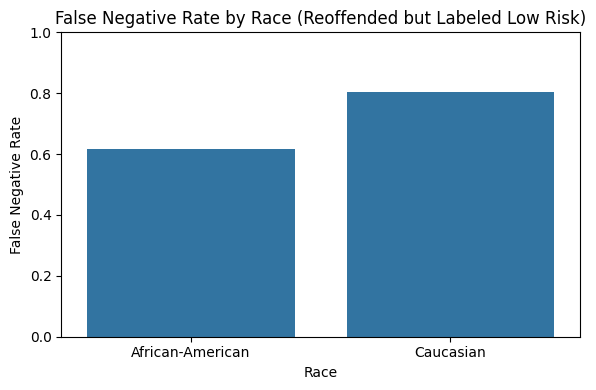

In [19]:
plt.figure(figsize=(6, 4))
sns.barplot(data=fnr_plot, x='race', y='FN')
plt.title('False Negative Rate by Race (Reoffended but Labeled Low Risk)')
plt.ylabel('False Negative Rate')
plt.xlabel('Race')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Step 5.2 | Error Balance: False Positive Rate by Race

In [20]:
EB_FP_model = scores[scores['two_year_recid'] == 0].copy()
EB_FP_model['FP'] = (EB_FP_model['high_risk'] == 1).astype(int)

fpr_plot = EB_FP_model.groupby('race')['FP'].mean().reset_index()

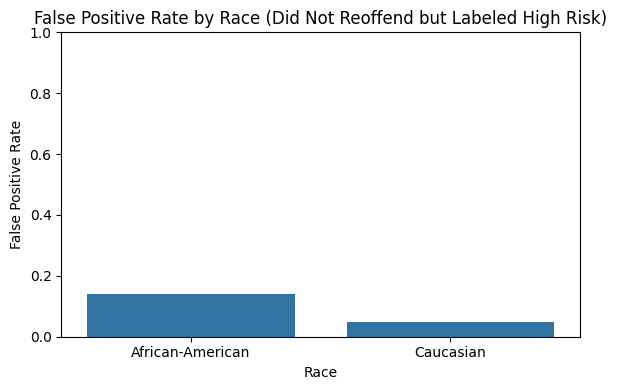

In [21]:
plt.figure(figsize=(6, 4))
sns.barplot(data=fpr_plot, x='race', y='FP')
plt.title('False Positive Rate by Race (Did Not Reoffend but Labeled High Risk)')
plt.ylabel('False Positive Rate')
plt.xlabel('Race')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Step 5.3 | Predictive Parity: PPV by Race

In [22]:
PP_PPV_model = scores[scores['high_risk'] == 1].copy()
PP_PPV_model['Correct'] = (PP_PPV_model['two_year_recid'] == 1).astype(int)

ppv_plot = PP_PPV_model.groupby('race')['Correct'].mean().reset_index()

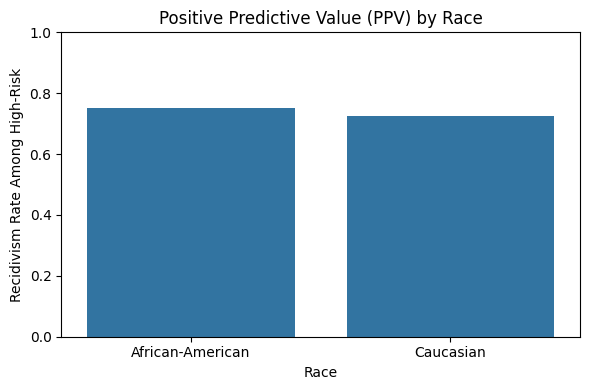

In [23]:
plt.figure(figsize=(6, 4))
sns.barplot(data=ppv_plot, x='race', y='Correct')
plt.title('Positive Predictive Value (PPV) by Race')
plt.ylabel('Recidivism Rate Among High-Risk')
plt.xlabel('Race')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Step 5.4 | Predictive Parity: NPV by Race

In [24]:
PP_NPV_model = scores[scores['high_risk'] == 0].copy()
PP_NPV_model['Correct'] = (PP_NPV_model['two_year_recid'] == 0).astype(int)

npv_plot = PP_NPV_model.groupby('race')['Correct'].mean().reset_index()

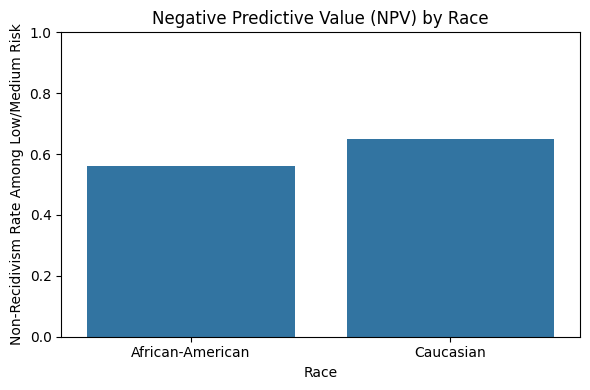

In [25]:
plt.figure(figsize=(6, 4))
sns.barplot(data=npv_plot, x='race', y='Correct')
plt.title('Negative Predictive Value (NPV) by Race')
plt.ylabel('Non-Recidivism Rate Among Low/Medium Risk')
plt.xlabel('Race')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Step 5.5 | Predictive Parity: Combined Chart

In [40]:
# Calculate PPV
PP_PPV_model = scores[scores['high_risk'] == 1].copy()
PP_PPV_model['Correct'] = (PP_PPV_model['two_year_recid'] == 1).astype(int)
ppv_plot = PP_PPV_model.groupby('race')['Correct'].mean().reset_index()
ppv_plot['Metric'] = 'PPV'

In [41]:
# Calculate NPV
PP_NPV_model = scores[scores['high_risk'] == 0].copy()
PP_NPV_model['Correct'] = (PP_NPV_model['two_year_recid'] == 0).astype(int)
npv_plot = PP_NPV_model.groupby('race')['Correct'].mean().reset_index()
npv_plot['Metric'] = 'NPV'

In [42]:
# Combine into one DataFrame
combined = pd.concat([ppv_plot, npv_plot])
combined = combined.rename(columns={'Correct': 'Value'})

In [44]:
# Custom color palette
custom_palette = {
    'African-American': '#7E57C2',  # purple
    'Caucasian': '#26A69A'          # teal
}

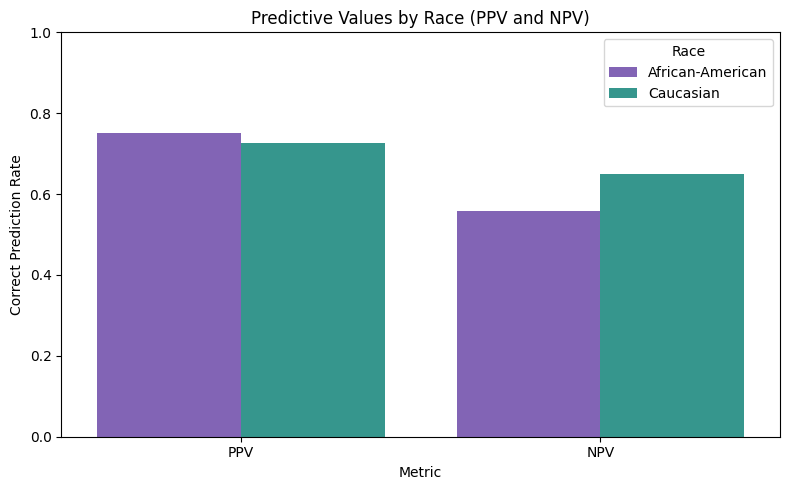

In [45]:
# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=combined, x='Metric', y='Value', hue='race', palette=custom_palette)
plt.title('Predictive Values by Race (PPV and NPV)')
plt.ylabel('Correct Prediction Rate')
plt.xlabel('Metric')
plt.ylim(0, 1)
plt.legend(title='Race')
plt.tight_layout()
plt.show()